# Example: div-k-grad-u inverse problem
# WORK IN PROGRESS, DO NOT USE

In [1]:
import numpy as np
from fenics import *
import matplotlib.pyplot as plt
from ufl import replace
from scipy.optimize import minimize

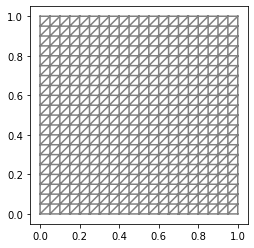

In [2]:
mesh_n = 20
mesh = UnitSquareMesh(mesh_n, mesh_n)
V = FunctionSpace(mesh, 'CG', 1)
plot(mesh)

For the forward problem, we use the inhomogeneous Poisson problem with Dirichlet boundary conditions:
$$\begin{cases}
-\nabla \cdot e^m \nabla u = f & \text{in } \Omega \\
u = 0 & \text{on } \partial \Omega,
\end{cases}$$
where the domain is the unit square, $\Omega=[0,1]^2$, $n$ is the normal to $\partial \Omega$, the parameter is 
$$m(x) = 1.25 + \sin\left(10\|x\|\right),$$
and the source is
$$m(x) = \exp\left(-\frac{\left\|x - p_1\right\|^2}{\sigma^2}\right) + \exp\left(-\frac{\left\|x - p_2\right\|^2}{\sigma^2}\right)$$
where $p_1 = (0.75,0.75)$, $p_2 = (0.25, 0.1)$, $\sigma = 0.1$$.

The weak form for this problem may be written as seeking $u \in H^1_0(\Omega)$ which satisfies
$$0 = g(m,u,v) := \int_\Omega \nabla v \cdot e^m \nabla u dx - \int_\Omega f v dx$$
for all $v \in H^1_0(\Omega)$.

In [3]:
u = Function(V)
v = Function(V)
m = Function(V)

m_true = Expression('1.25 + sin(10*sqrt(pow(x[0],2) + pow(x[1],2)))', degree=5)

f1 = Expression('exp(- (pow(x[0]-a,2) + pow(x[1]-b,2))/s)', a=0.5, b=0.5, s=0.02, degree=5)
# f2 = Expression('exp(- (pow(x[0]-a,2) + pow(x[1]-b,2))/s)', a=0.1, b=0.1, s=0.02, degree=5)
# f = f1 + f2
f = f1

m_true_vector = project(m_true, V).vector()
m.vector()[:] = m_true_vector[:].copy()

Text(0.5, 1.0, 'true parameter m')

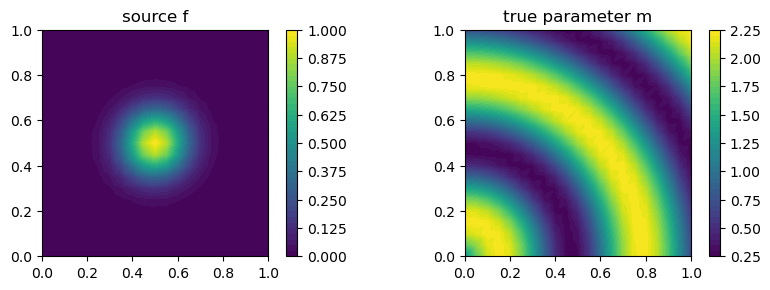

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3), dpi= 100)
plt.sca(axs[0])
cm = plot(f, mesh=mesh)
plt.colorbar(cm)
plt.title('source f')

plt.sca(axs[1])
cm = plot(m_true, mesh=mesh)
plt.colorbar(cm)
plt.title('true parameter m')

In [5]:
forward_form_base = (inner(exp(m) * grad(u), grad(v))*dx) - (f * v * dx)

forward_form0 = replace(forward_form_base, {v:TestFunction(V)})

forward_form = replace(forward_form_base, {u:TrialFunction(V), v:TestFunction(V)})
forward_lhs = lhs(forward_form)
forward_rhs = rhs(forward_form)

def the_boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant(0.0), the_boundary)

G = assemble(forward_lhs)
bc.apply(G)
G_solver = LUSolver(G)

def solve_forward():
    b = assemble(forward_rhs)
    bc.apply(b)
    G_solver.solve(u.vector(), b)
    
solve_forward()

Text(0.5, 1.0, 'true u')

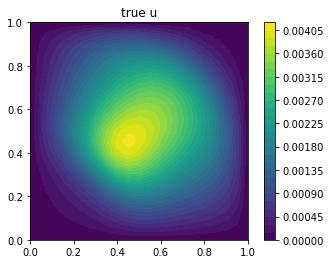

In [6]:
cm = plot(u)
plt.colorbar(cm)
plt.title('true u')

The data misfit function is
$$J_d(m) := \int_{\partial \Omega} \left(\nu \cdot e^m\nabla u(m) - \nu \cdot e^m \nabla u_\text{true}\right)^2 ds.$$

In [7]:
u_true = Function(V)
u_true.vector()[:] = u.vector()[:].copy()

nu = FacetNormal(mesh)

Jd_form = pow(inner(nu, exp(m) * grad(u - u_true)), 2) * ds

def compute_data_misfit():
    return assemble(Jd_form)

Jd_true = compute_data_misfit()
print('Jd_true=', Jd_true)

Jd_true= 0.0


In [8]:
def update_m(new_m_vector):
    global G 
    global G_solver
    m.vector()[:] = new_m_vector[:].copy()
    G = assemble(forward_lhs)
    bc.apply(G)
    G_solver = LUSolver(G)

In [9]:
zero_vector = Function(V).vector()

update_m(zero_vector)
solve_forward()
Jd_0 = compute_data_misfit()

print('Jd_0=', Jd_0)

Jd_0= 0.0005339860257976057


Text(0.5, 1.0, 'u at m=0')

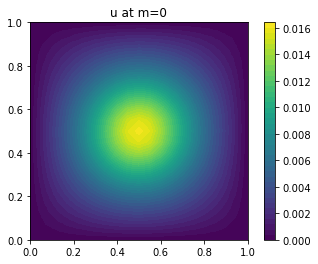

In [10]:
cm1 = plot(u)
plt.colorbar(cm1)
plt.title('u at m=0')

The Lagrangian is
$$\mathcal{L}(m,u,v) := J(m,u,v) + g(m,u,v).$$
We seek an the adjoint variable $v \in H^1_0(\Omega)$ that solves the following adjoint equation
$$0 = a(m,u,v,\widetilde{u}) := \frac{\partial \mathcal{L}}{\partial u}(m,u,v,\widetilde{u}) = 0$$
for all $\widetilde{u} \in H^1_0(\Omega)$.

In [11]:
lagrangian_form = Jd_form + forward_form_base

adjoint_form0 = derivative(lagrangian_form, u, TestFunction(V))

adjoint_form = replace(adjoint_form0, {v:TrialFunction(V)})
adjoint_lhs = lhs(adjoint_form)
adjoint_rhs = rhs(adjoint_form)

Gt = assemble(adjoint_lhs)
bc.apply(Gt)
Gt_solver = LUSolver(Gt)

def solve_adjoint():
    b = assemble(adjoint_rhs)
    bc.apply(b)
#     Gt_solver.solve(v.vector(), b)
    G_solver.solve(v.vector(), b) # symmetric

solve_adjoint()

In [12]:
[print(a) for a in adjoint_form.arguments()]

v_0
v_1


[None, None]

Text(0.5, 1.0, 'adjoint v')

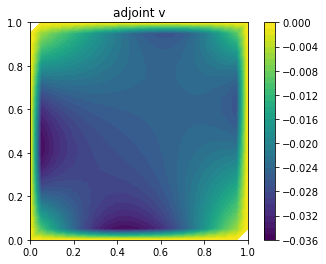

In [13]:
cm = plot(v)
plt.colorbar(cm)
plt.title('adjoint v')

The gradient dual function is given by 
$$g(h) = \frac{\partial \mathcal{L}}{\partial m}(m,u,v)h.$$
The Riesz representative of the gradient is given by the function $g_\text{Riesz}$ satisfying
$$\int_\Omega h g_\text{Riesz} dx = g(h)$$
for all $v$.

In [14]:
mass_form = TrialFunction(V) * TestFunction(V) * dx
M = assemble(mass_form)

M_solver = LUSolver(M)

In [15]:
gradient_form0 = derivative(lagrangian_form, m, TestFunction(V))

def compute_gradient(return_riesz_representative=False):
    g_dual_vector = assemble(gradient_form0)
    
    if return_riesz_representative:
        g_riesz_representative = Function(V)
        M_solver.solve(g_riesz_representative.vector(), g_dual_vector)
        return g_dual_vector, g_riesz_representative
    else:
        return g_dual_vector

g_dual0, g_riesz0 = compute_gradient(return_riesz_representative=True)

Text(0.5, 1.0, 'gradient (riesz representative)')

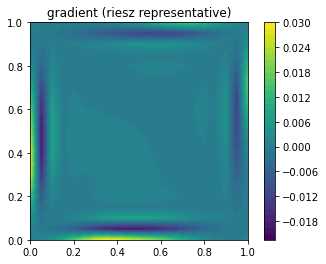

In [16]:
cm = plot(g_riesz0)
plt.colorbar(cm)
plt.title('gradient (riesz representative)')

In [17]:
m_original_numpy_vector = m.vector()[:].copy()

s = 1e-6
dm = Function(V)
dm.vector()[:] = np.random.randn(V.dim()) # perturb m a small bit

update_m(m_original_numpy_vector + s * dm.vector()[:])

solve_forward()
Jd_1 = compute_data_misfit()
solve_adjoint()
g_dual1, g_riesz1 = compute_gradient(return_riesz_representative=True)


update_m(m_original_numpy_vector) # Reset to original m

In [18]:
dJ_diff = (Jd_1 - Jd_0)/s

dJ = np.dot(g_dual0[:], dm.vector()[:])

err_grad = (dJ - dJ_diff)/dJ_diff
print('s=', s, ', err_grad=', err_grad)

s= 1e-06 , err_grad= 4.6329584126335085e-06


# Hessian vector products

$$Hp = \frac{dg(m,u,v}{dm}p = \frac{\partial g}{\partial m}p + \frac{\partial g}{\partial u}\underbrace{\frac{du}{dm}p}_{\text{icru}} + \frac{\partial g}{\partial v}\underbrace{\frac{dv}{dm}p}_{\text{icrv}}$$

$$Hp = \frac{dg(m,u,v}{dm}p = \frac{\partial g}{\partial m}p + \frac{\partial g}{\partial u}u_p + \frac{\partial g}{\partial v}v_p$$

In [19]:
p = Function(V) # Function to apply the Hessian to (p -> Hp)
icru = Function(V) # incremental state
icrv = Function(V) # incremental adjoint

# Hessian vector product is directional derivative of gradient
hessian_form0 = (derivative(gradient_form0, m, p)
                + derivative(gradient_form0, u, icru)
                + derivative(gradient_form0, v, icrv))

Take derivative of forward equation to get incremental forward equation
$$0 = \mathcal{G}(m,u)$$
$$0 = \frac{d}{dm}\mathcal{G}(m,u)p = \frac{\partial \mathcal{G}}{\partial m} p + \frac{\partial \mathcal{G}}{\partial u} u_p$$

In [20]:
# Incremental forward equation is total derivative of forward equation
incremental_forward_form0 = (derivative(forward_form0, m, p) 
                             + derivative(forward_form0, u, icru))

incremental_forward_form = replace(incremental_forward_form0, {icru:TrialFunction(V)})
incremental_forward_rhs = rhs(incremental_forward_form)

take derivative of adjoint equation to get incremental adjoint equation
$$0 = \mathcal{A}(m,u,v)$$
$$0 = \frac{d}{dm}\mathcal{A}(m,u,v)p = \frac{\partial \mathcal{A}}{\partial m} p + \frac{\partial \mathcal{A}}{\partial u} u_p + \frac{\partial \mathcal{A}}{\partial v} v_p$$

In [21]:
# Incremental adjoint equation is total derivative of adjoint equation
incremental_adjoint_form0 = (derivative(adjoint_form0, m, p) 
                             + derivative(adjoint_form0, u, icru) 
                             + derivative(adjoint_form0, v, icrv))

incremental_adjoint_form = replace(incremental_adjoint_form0, {icrv:TrialFunction(V)})
incremental_adjoint_rhs = rhs(incremental_adjoint_form)

In [22]:
def solve_incremental_forward():
    b = assemble(incremental_forward_rhs)
    bc.apply(b)
    G_solver.solve(icru.vector(), b)

In [23]:
def solve_incremental_adjoint():
    b = assemble(incremental_adjoint_rhs)
    bc.apply(b)
#     G_solver.solve_transpose(v.vector(), b)
    G_solver.solve(icrv.vector(), b) # symmetric

In [24]:
def compute_hessian_vector_product(p_vector):
    p.vector()[:] = p_vector[:].copy()
    
    solve_incremental_forward()
    solve_incremental_adjoint()
    Hp = assemble(hessian_form0)
    return Hp

In [25]:
update_m(m_original_numpy_vector) # Reset to original m

solve_forward()
solve_adjoint()
Hdm = compute_hessian_vector_product(dm.vector()[:].copy())

In [26]:
Hdm_diff = (g_dual1[:] - g_dual0[:])/s
err_hess = np.linalg.norm(Hdm_diff - Hdm[:])/np.linalg.norm(Hdm_diff)
print('s=', s, ', err_hess=', err_hess)

s= 1e-06 , err_hess= 1.0116124454976178e-06


## Regularization
$$J_R = \frac{1}{2} \left(\int_\Omega \|\nabla m\|^2 dx + 0.1 \int_\Omega m^2 dx\right)$$
$$\frac{d^2 J_R}{dm^2} = R = \Delta_N + 0.1 M$$
where $\Delta_N$ is discretized Neumann Laplacian, and $M$ is mass matrix.
$$M_{ij} := \int_\Omega \phi_i \phi_j dx$$
$$\left(\Delta_N\right)_{ij} := \int_\Omega \nabla \phi_i \cdot \nabla \phi_j dx$$

In [27]:
regularization_form0 = 0.5 * (inner(grad(m), grad(m)) * dx + 0.1 * m * m * dx)
regularization_gradient_form = derivative(regularization_form0, m, TestFunction(V))
regularization_hessian_form = derivative(regularization_gradient_form, m, TrialFunction(V))
R3 = assemble(regularization_hessian_form)

In [28]:
mass_form = TestFunction(V) * TrialFunction(V) * dx
M = assemble(mass_form)

neumann_laplacian_form = inner(grad(TestFunction(V)), grad(TrialFunction(V))) * dx
Delta_N = assemble(neumann_laplacian_form)

regularization_form = neumann_laplacian_form + 0.1*mass_form

R0 = assemble(regularization_form)
R = Delta_N + 0.1 * M

In [29]:
z = Function(V)
z.vector()[:] = np.random.randn(V.dim())
w = R0 * z.vector() - R * z.vector()
np.linalg.norm(w[:])

1.7524387769623282e-14

In [30]:
z = Function(V)
z.vector()[:] = np.random.randn(V.dim())
w = R0 * z.vector() - R3 * z.vector()
np.linalg.norm(w[:])

0.0

## Optimize

In [65]:
a_reg = 1e-2 # regularization parameter

def fun(m_numpy):
    if True:
#     if np.linalg.norm(m_numpy - m.vector()[:]) > 1e-12:
        update_m(m_numpy)
#         m.vector()[:] = m_numpy
    solve_forward()
    return compute_data_misfit() + a_reg * assemble(regularization_form0)
    

def jac(m_numpy):
    if True:
#     if np.linalg.norm(m_numpy - m.vector()[:]) > 1e-12:
#         m.vector()[:] = m_numpy
        update_m(m_numpy)
        solve_forward()
    solve_adjoint()
    gd = compute_gradient()
    gr = a_reg * assemble(regularization_gradient_form)
    return gd[:] + gr[:]


dm = Function(V)
def hessp(m_numpy, dm_numpy):
    if True:
#     if np.linalg.norm(m_numpy - m.vector()[:]) > 1e-12:
#         m.vector()[:] = m_numpy
        update_m(m_numpy)
        solve_forward()
        solve_adjoint()
    dm.vector()[:] = dm_numpy
    Hd_dm = compute_hessian_vector_product(dm.vector())
    HR_dm = a_reg * (R3 * dm.vector())
    return Hd_dm[:] + HR_dm[:]

s= 1.0 , err_grad= -0.7016724156182572 , err_hess= 0.7622958176499427
s= 0.1 , err_grad= -0.10869656206625009 , err_hess= 0.08406025200288453
s= 0.01 , err_grad= -0.011576716330641057 , err_hess= 0.008192765170317627
s= 0.001 , err_grad= -0.00116537465650549 , err_hess= 0.000816917695654504
s= 0.0001 , err_grad= -0.00011661492932271009 , err_hess= 8.166773636793542e-05
s= 1e-05 , err_grad= -1.166201328641008e-05 , err_hess= 8.16627687458218e-06
s= 1e-06 , err_grad= -1.1654192906684496e-06 , err_hess= 8.161699916594858e-07
s= 1e-07 , err_grad= -1.1913244081528026e-07 , err_hess= 1.1268902050540948e-07
s= 1e-08 , err_grad= 6.261480992577272e-08 , err_hess= 7.021323807983847e-07
s= 1e-09 , err_grad= -4.663217931442155e-08 , err_hess= 5.116304479300774e-06
s= 1e-10 , err_grad= 3.7273685524422257e-06 , err_hess= 7.784098524572811e-05
s= 1e-11 , err_grad= -7.1972922888072305e-06 , err_hess= 0.000765639348048219
s= 1e-12 , err_grad= -0.0002057858739009036 , err_hess= 0.008156568802210905
s= 1

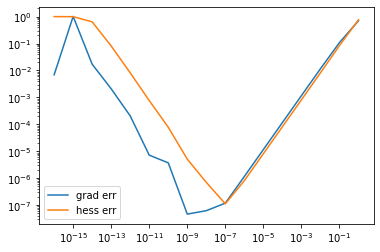

In [66]:
m0 = Expression('cos(x[0]) + x[1]', degree=5)
m0_numpy = project(m0, V).vector()[:]

dmE = Expression('sin(x[1]) + x[1]*x[0]', degree=5)
dm_numpy = project(dmE, V).vector()[:]

# m0_numpy = np.random.randn(V.dim()) # error big: maybe because of quadrature error near boundary..?
# dm_numpy = np.random.randn(V.dim())

J0 = fun(m0_numpy)
grad0 = jac(m0_numpy)
dJ = np.dot(grad0, dm_numpy)
Hdm = hessp(m0_numpy, dm_numpy)

ss = np.logspace(-16, 0, 17)[::-1]
grad_errs = []
hess_errs = []
for k in range(len(ss)):
    s = ss[k]
    m1_numpy = m0_numpy + s * dm_numpy
    J1 = fun(m1_numpy)
    grad1 = jac(m1_numpy)
    dJ1 = np.dot(grad1, dm_numpy)
    
    dJ_diff = (J1 - J0)/s
    err_grad = (dJ - dJ_diff)/dJ_diff
    grad_errs.append(err_grad)
    
    Hdm_diff = (grad1 - grad0)/s
    err_hess = np.linalg.norm(Hdm_diff - Hdm)/np.linalg.norm(Hdm_diff)
    hess_errs.append(err_hess)
    
    print('s=', s, ', err_grad=', err_grad, ', err_hess=', err_hess)
    
plt.loglog(ss, np.abs(grad_errs))
plt.loglog(ss, np.abs(hess_errs))
plt.legend(['grad err', 'hess err'])

In [58]:
dJ_diff

2.220446049250313

In [67]:
soln = minimize(fun, np.zeros(V.dim()), args=(), method='trust-ncg', jac=jac, hessp=hessp, tol=1e-6, callback=None, options={})

In [60]:
soln

     fun: 0.0005325597991160136
     jac: array([ 2.35194875e-11, -1.01981083e-11, -3.80499408e-12,  5.04363659e-11,
        3.52696384e-11,  3.14185543e-11, -3.13832807e-11, -7.06341268e-11,
        2.47271936e-11, -2.78482809e-12, -2.32337266e-11,  8.15401217e-11,
        1.07101815e-10,  4.68810721e-12, -3.72407219e-11, -4.11707741e-11,
       -4.92302021e-11, -1.57666821e-11,  1.96933307e-11,  5.42930036e-12,
       -3.70952495e-11,  1.60299790e-11,  5.83612533e-11,  5.70891937e-11,
       -4.15755338e-12, -8.47008796e-11, -9.84119610e-11, -1.91187613e-11,
       -9.72246473e-12, -4.39952134e-11, -1.65007531e-11,  1.42898589e-10,
       -4.79314910e-12,  4.28193955e-11,  4.97245887e-11,  4.13135147e-11,
       -6.36625639e-11, -4.52545851e-11,  5.65733553e-11,  9.17834245e-11,
       -7.91079647e-12, -1.54731897e-10, -3.26130335e-11,  5.61017265e-11,
        5.43955517e-11,  4.84768292e-12,  2.63029890e-11,  2.27597732e-11,
        1.17620979e-10, -1.09680686e-10,  8.20644355e-12, 

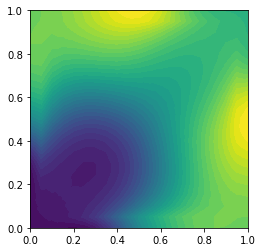

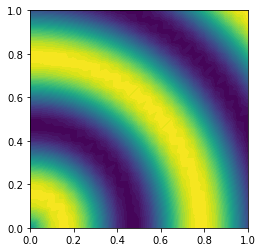

In [68]:
m_reconstructed = Function(V)
m_reconstructed.vector()[:] = soln.x
plot(m_reconstructed)
plt.figure()
plot(m_true, mesh=mesh)